<a href="https://www.kaggle.com/code/hkafrawi/understanding-usd-price-through-gold?scriptVersionId=141186458" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from IPython.display import Image, HTML


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('/kaggle/input/gold-price-egp-telegram-channel-scrapped/export.csv')
cbe_df = pd.read_excel('/kaggle/input/cbe-egp-exchange-rates-2016-august-23-2023/Exchange Rates Historical.xlsx')
gold_df = pd.read_csv('/kaggle/input/gold-and-silver-prices-2013-2023/gold prices.csv')

# Explore the Data

In [3]:
df.head()

,text,date
0,بسم لله... جمعة مباركة 🤲 ...اللهم صلِّ صلاةً ك...,2021-01-01 08:57:49+00:00
1,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-01 08:58:10+00:00
2,بسم لله... صباحكم كله رزق أن شآء الله ♥,2021-01-02 09:29:27+00:00
3,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-02 09:29:35+00:00
4,بسم لله... صباحكم كله رزق أن شآء الله ♥,2021-01-03 09:49:52+00:00


In [4]:
df.iloc[1,0]

'☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨          ٧٠٩ جنيه \n⬅️عيار ٢١          ٨٢٧ جنيه \n⬅️عيار ٢٤         ٩٤٥ جنيه'

In [5]:
df.iloc[2,0]

'بسم لله... صباحكم كله رزق أن شآء الله ♥'

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8806 entries, 0 to 8805
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    8586 non-null   object
 1   date    8806 non-null   object
dtypes: object(2)
memory usage: 137.7+ KB


In [7]:
df[df['text'].isnull()]

,text,date
1191,NaN,2021-04-12 21:14:53+00:00
1409,NaN,2021-05-12 16:36:46+00:00
1937,NaN,2021-07-18 17:29:12+00:00
1945,NaN,2021-07-20 02:31:07+00:00
2078,NaN,2021-08-08 21:40:40+00:00
...,...,...
8588,NaN,2023-06-27 08:50:23+00:00
8589,NaN,2023-06-27 09:02:09+00:00
8693,NaN,2023-07-21 08:29:42+00:00
8703,NaN,2023-07-22 20:28:05+00:00


In [8]:
df[df['text'].isnull()].index

Int64Index([1191, 1409, 1937, 1945, 2078, 2684, 2867, 2943, 3010, 3048,
            ...
            8381, 8435, 8449, 8545, 8587, 8588, 8589, 8693, 8703, 8729],
           dtype='int64', length=220)

In [9]:
df.iloc[8000,0]

'☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨\xa0\xa0\xa0\xa0\xa0\xa0\xa0 \xa0\xa0\xa0 ١٨٥١\xa0 جنيه \n⬅️عيار ٢١\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 \xa0\xa0 ٢١٦٠\xa0 جنيه \n⬅️عيار ٢٤\xa0\xa0\xa0\xa0\xa0 \xa0\xa0\xa0\xa0 ٢٤٦٩ \xa0 جنيه\n⬅️ الجنيه ذهب \xa0 ١٧٢٨٠\xa0 جنيه \n\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 \xa0\xa0\xa0\xa0\xa0\xa0 ➖➖➖ ➖➖➖\nالأسعار لا تشمل المصنعيه\xa0 \n\n\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 ➖➖➖ ➖➖➖\nسعر الذهب العالمي💲\xa0 \n٢٠٠٨ دولار للأونصه'

In [10]:
df.iloc[1,0]

'☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨          ٧٠٩ جنيه \n⬅️عيار ٢١          ٨٢٧ جنيه \n⬅️عيار ٢٤         ٩٤٥ جنيه'

* There are null text rows that need to be elimintated
* Not all text rows contain information about gold price
* the format of the message changed since inception and carry more information


# Clean and Prepare the Dataset

In [11]:
dfv2 = df.drop(df[df['text'].isnull()].index,axis=0)

In [12]:
dfv2.iloc[0,0].find("\n")

-1

In [13]:
dfv2.iloc[0,0]

'بسم لله... جمعة مباركة 🤲 ...اللهم صلِّ صلاةً كاملةً، وسلّم سلامًا تامًّا على سيدنا محمد ♥'

In [14]:
dfv2.iloc[8000,0].find("\n")

19

In [15]:
dfv3 = dfv2[dfv2['text'].str.contains("\n")]

In [16]:
dfv4 = dfv3[~dfv3['text'].str.contains("الله")]

In [17]:
dfv4.reset_index(inplace=True)

In [18]:
dfv4.drop('index',axis=1,inplace=True)

/tmp/ipykernel_20/302208537.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfv4.drop('index',axis=1,inplace=True)


In [19]:
dfv4.head()

,text,date
0,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-01 08:58:10+00:00
1,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-02 09:29:35+00:00
2,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-03 09:50:01+00:00
3,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٢٠ ...,2021-01-04 09:16:55+00:00
4,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧١٩ ...,2021-01-04 10:31:18+00:00


In [20]:
dfv4['text_list'] = dfv4['text'].apply(lambda x:x.split("\n"))

/tmp/ipykernel_20/3287723382.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfv4['text_list'] = dfv4['text'].apply(lambda x:x.split("\n"))


In [21]:
dfv4.head()

,text,date,text_list
0,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-01 08:58:10+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩..."
1,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-02 09:29:35+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩..."
2,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-03 09:50:01+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩..."
3,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٢٠ ...,2021-01-04 09:16:55+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٢٠..."
4,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧١٩ ...,2021-01-04 10:31:18+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧١٩..."


In [22]:
def get_price(regex:str, expressions:list,end:bool = True):
    if end:
        for expression in expressions:
            if x := re.search(regex,expression):
                return expression[x.end()+1:].strip()
    else:
        for expression in expressions:
            if x := re.search(regex,expression):
                return expression[:x.start()].strip()

In [23]:
dfv4['g 18k EGP'] = dfv4['text_list'].apply(lambda expressions:get_price('عيار ١٨',expressions))
dfv4['g 21k EGP'] = dfv4['text_list'].apply(lambda expressions:get_price('عيار ٢١',expressions))
dfv4['g 24k EGP'] = dfv4['text_list'].apply(lambda expressions:get_price('عيار ٢٤',expressions))
dfv4['Gold Coin EGP'] = dfv4['text_list'].apply(lambda expressions:get_price('الجنيه ذهب',expressions))
dfv4['Oz 24k USD'] = dfv4['text_list'].apply(lambda expressions:get_price('دولار',expressions,end=False))

/tmp/ipykernel_20/3550805074.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfv4['g 18k EGP'] = dfv4['text_list'].apply(lambda expressions:get_price('عيار ١٨',expressions))
/tmp/ipykernel_20/3550805074.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfv4['g 21k EGP'] = dfv4['text_list'].apply(lambda expressions:get_price('عيار ٢١',expressions))
/tmp/ipykernel_20/3550805074.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [24]:
dfv4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7340 entries, 0 to 7339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           7340 non-null   object
 1   date           7340 non-null   object
 2   text_list      7340 non-null   object
 3   g 18k EGP      6916 non-null   object
 4   g 21k EGP      6919 non-null   object
 5   g 24k EGP      6916 non-null   object
 6   Gold Coin EGP  1772 non-null   object
 7   Oz 24k USD     2932 non-null   object
dtypes: object(8)
memory usage: 458.9+ KB


In [25]:
dfv4.head()

,text,date,text_list,g 18k EGP,g 21k EGP,g 24k EGP,Gold Coin EGP,Oz 24k USD
0,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-01 08:58:10+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",٧٠٩ جنيه,٨٢٧ جنيه,٩٤٥ جنيه,None,None
1,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-02 09:29:35+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",٧٠٩ جنيه,٨٢٧ جنيه,٩٤٥ جنيه,None,None
2,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-03 09:50:01+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",٧٠٩ جنيه,٨٢٧ جنيه,٩٤٥ جنيه,None,None
3,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٢٠ ...,2021-01-04 09:16:55+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٢٠...",٧٢٠ جنيه,٨٤٠ جنيه,٩٦٠ جنيه,None,None
4,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧١٩ ...,2021-01-04 10:31:18+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧١٩...",٧١٩ جنيه,٨٣٩ جنيه,٩٥٩ جنيه,None,None


In [26]:
dfv4[dfv4['g 18k EGP'].isnull()]

,text,date,text_list,g 18k EGP,g 21k EGP,g 24k EGP,Gold Coin EGP,Oz 24k USD
944,☆أسِـعٌأّر أّلَذهّـبً أّلَآنِ🇪🇬\n\n⬅️عٌيِّأّر ...,2021-03-23 08:45:03+00:00,"[☆أسِـعٌأّر أّلَذهّـبً أّلَآنِ🇪🇬, , ⬅️عٌيِّأّر...",None,None,None,None,None
1078,للإعلان على القناة 👇🏻👇🏻👇🏻👇🏻👇🏻👇🏻\n\n@G...,2021-04-11 15:26:28+00:00,"[للإعلان على القناة 👇🏻👇🏻👇🏻👇🏻👇🏻👇🏻, , @...",None,None,None,None,None
1087,🌙♥️ ‌‏﮼كل‏﮼سنه‏﮼وانتم ‏﮼بألف ‏﮼خير \n ...,2021-04-12 21:37:29+00:00,"[🌙♥️ ‌‏﮼كل‏﮼سنه‏﮼وانتم ‏﮼بألف ‏﮼خير , ...",None,None,None,None,None
1096,قناة اسعار الذهب لحظه بلحظه \nنتمنى لكم صوما م...,2021-04-13 16:22:51+00:00,"[قناة اسعار الذهب لحظه بلحظه , نتمنى لكم صوما ...",None,None,None,None,None
1106,قناة اسعار الذهب لحظه بلحظه \nنتمنى لكم صوما م...,2021-04-14 16:21:28+00:00,"[قناة اسعار الذهب لحظه بلحظه , نتمنى لكم صوما ...",None,None,None,None,None
...,...,...,...,...,...,...,...,...
7274,📣عرض اليوم🔥\nعلى سبيكه نص كيلو \n📌 بدون مصنعية...,2023-07-26 11:34:57+00:00,"[📣عرض اليوم🔥, على سبيكه نص كيلو , 📌 بدون مصنعي...",None,None,None,None,None
7275,⭐️⭐️العرض انتهى\nمبروك للمشترى ⭐️⭐️⭐️,2023-07-26 15:09:32+00:00,"[⭐️⭐️العرض انتهى, مبروك للمشترى ⭐️⭐️⭐️]",None,None,None,None,None
7276,**🔵صدر الآن، قرار الفائدة الصادر عن البنك الفي...,2023-07-26 18:01:22+00:00,[**🔵صدر الآن، قرار الفائدة الصادر عن البنك الف...,None,None,None,None,None
7295,⚡️عشان يظهر لك عروض كل يوم لازم تكون مسجل ال...,2023-08-01 19:51:55+00:00,[⚡️عشان يظهر لك عروض كل يوم لازم تكون مسجل ا...,None,None,None,None,None


In [27]:
dfv5 = dfv4.drop(dfv4[dfv4['g 18k EGP'].isnull()].index,axis=0)

In [28]:
dfv5.head()

,text,date,text_list,g 18k EGP,g 21k EGP,g 24k EGP,Gold Coin EGP,Oz 24k USD
0,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-01 08:58:10+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",٧٠٩ جنيه,٨٢٧ جنيه,٩٤٥ جنيه,None,None
1,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-02 09:29:35+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",٧٠٩ جنيه,٨٢٧ جنيه,٩٤٥ جنيه,None,None
2,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-03 09:50:01+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",٧٠٩ جنيه,٨٢٧ جنيه,٩٤٥ جنيه,None,None
3,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٢٠ ...,2021-01-04 09:16:55+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٢٠...",٧٢٠ جنيه,٨٤٠ جنيه,٩٦٠ جنيه,None,None
4,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧١٩ ...,2021-01-04 10:31:18+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧١٩...",٧١٩ جنيه,٨٣٩ جنيه,٩٥٩ جنيه,None,None


In [29]:
dfv5[dfv5['Oz 24k USD'].isnull()]

,text,date,text_list,g 18k EGP,g 21k EGP,g 24k EGP,Gold Coin EGP,Oz 24k USD
0,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-01 08:58:10+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",٧٠٩ جنيه,٨٢٧ جنيه,٩٤٥ جنيه,None,None
1,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-02 09:29:35+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",٧٠٩ جنيه,٨٢٧ جنيه,٩٤٥ جنيه,None,None
2,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-03 09:50:01+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",٧٠٩ جنيه,٨٢٧ جنيه,٩٤٥ جنيه,None,None
3,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٢٠ ...,2021-01-04 09:16:55+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٢٠...",٧٢٠ جنيه,٨٤٠ جنيه,٩٦٠ جنيه,None,None
4,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧١٩ ...,2021-01-04 10:31:18+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧١٩...",٧١٩ جنيه,٨٣٩ جنيه,٩٥٩ جنيه,None,None
...,...,...,...,...,...,...,...,...
4020,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٨٩٢...,2022-04-18 10:15:01+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٨٩...",٨٩٢ جنيه,١٠٤١ جنيه,١١٨٩ جنيه,None,None
4021,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٨٩١...,2022-04-18 10:27:08+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٨٩...",٨٩١ جنيه,١٠٤٠ جنيه,١١٨٨ جنيه,None,None
4023,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٨٩٢...,2022-04-18 11:12:43+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٨٩...",٨٩٢ جنيه,١٠٤١ جنيه,١١٨٩ جنيه,None,None
4024,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٨٩٣...,2022-04-18 11:34:29+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٨٩...",٨٩٣ جنيه,١٠٤٢ جنيه,١١٩٠ جنيه,None,None


In [30]:
dfv5['g 18k EGP'] = dfv5['g 18k EGP'].apply(lambda x:x.replace('جنيه','').strip())
dfv5['g 21k EGP'] = dfv5['g 21k EGP'].apply(lambda x:x.replace('جنيه','').strip())
dfv5['g 24k EGP'] = dfv5['g 24k EGP'].apply(lambda x:x.replace('جنيه','').strip())
dfv5['g 24k EGP'] = dfv5['g 24k EGP'].apply(lambda x:x.replace('جني',''))

In [31]:
dfv5['Gold Coin EGP'] = dfv5['Gold Coin EGP'].apply(lambda x: x.replace('جنيه','').strip() if type(x) is str else x)

In [32]:
dfv5.head()

,text,date,text_list,g 18k EGP,g 21k EGP,g 24k EGP,Gold Coin EGP,Oz 24k USD
0,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-01 08:58:10+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",٧٠٩,٨٢٧,٩٤٥,None,None
1,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-02 09:29:35+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",٧٠٩,٨٢٧,٩٤٥,None,None
2,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-03 09:50:01+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",٧٠٩,٨٢٧,٩٤٥,None,None
3,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٢٠ ...,2021-01-04 09:16:55+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٢٠...",٧٢٠,٨٤٠,٩٦٠,None,None
4,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧١٩ ...,2021-01-04 10:31:18+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧١٩...",٧١٩,٨٣٩,٩٥٩,None,None


In [33]:
float(dfv5['g 18k EGP'][0])

709.0

In [34]:
dfv5[dfv5['g 18k EGP'].str.contains("/")].index

Int64Index([2529], dtype='int64')

In [35]:
dfv6 = dfv5.drop(dfv5[dfv5['g 18k EGP'].str.contains("/")].index, axis =0)

In [36]:
dfv6.head()

,text,date,text_list,g 18k EGP,g 21k EGP,g 24k EGP,Gold Coin EGP,Oz 24k USD
0,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-01 08:58:10+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",٧٠٩,٨٢٧,٩٤٥,None,None
1,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-02 09:29:35+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",٧٠٩,٨٢٧,٩٤٥,None,None
2,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-03 09:50:01+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",٧٠٩,٨٢٧,٩٤٥,None,None
3,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٢٠ ...,2021-01-04 09:16:55+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٢٠...",٧٢٠,٨٤٠,٩٦٠,None,None
4,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧١٩ ...,2021-01-04 10:31:18+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧١٩...",٧١٩,٨٣٩,٩٥٩,None,None


In [37]:
dfv6['g 18k EGP'] = dfv6['g 18k EGP'].apply(lambda x:float(x))
dfv6['g 21k EGP'] = dfv6['g 21k EGP'].apply(lambda x:float(x))
dfv6['g 24k EGP'] = dfv6['g 24k EGP'].apply(lambda x:float(x))

In [38]:
dfv6[(~dfv6['Oz 24k USD'].isnull())&(dfv6['Oz 24k USD'].str.contains('و'))]

,text,date,text_list,g 18k EGP,g 21k EGP,g 24k EGP,Gold Coin EGP,Oz 24k USD
7019,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٢٠...,2023-05-27 12:40:56+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٢...",2024.0,2360.0,2697.0,١٨٨٨٠,١٩٤٦و
7021,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٢٠...,2023-05-27 17:21:43+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٢...",2024.0,2360.0,2697.0,١٨٨٨٠,١٩٤٦و
7022,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٢٠...,2023-05-28 10:23:43+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٢...",2024.0,2360.0,2697.0,١٨٨٨٠,١٩٤٦و


In [39]:
dfv6[(~dfv6['Oz 24k USD'].isnull())&(dfv6['Oz 24k USD'].str.contains('الذهب'))]

,text,date,text_list,g 18k EGP,g 21k EGP,g 24k EGP,Gold Coin EGP,Oz 24k USD
7288,⭐️⭐️☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ...,2023-07-29 09:47:45+00:00,"[⭐️⭐️☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ...",1848.0,2155.0,2463.0,١٧٢٤٠,سعر الذهب العالمي💲 ١٩٥٩


In [40]:
dfv6.loc[7019,'Oz 24k USD'] = 1946
dfv6.loc[7021,'Oz 24k USD'] = 1946
dfv6.loc[7022,'Oz 24k USD'] = 1946
dfv6.loc[7288,'Oz 24k USD'] = 1959

In [41]:
dfv6 = dfv6.fillna(np.nan)

In [42]:
dfv6['Gold Coin EGP'] = dfv6['Gold Coin EGP'].apply(lambda x:float(x))
dfv6['Oz 24k USD'] = dfv6['Oz 24k USD'].apply(lambda x:float(x))

In [43]:
dfv6.head()

,text,date,text_list,g 18k EGP,g 21k EGP,g 24k EGP,Gold Coin EGP,Oz 24k USD
0,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-01 08:58:10+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",709.0,827.0,945.0,NaN,NaN
1,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-02 09:29:35+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",709.0,827.0,945.0,NaN,NaN
2,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٠٩ ...,2021-01-03 09:50:01+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٠٩...",709.0,827.0,945.0,NaN,NaN
3,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧٢٠ ...,2021-01-04 09:16:55+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧٢٠...",720.0,840.0,960.0,NaN,NaN
4,☆أسعار الذهب الآن🇪🇬\n\n⬅️عيار ١٨ ٧١٩ ...,2021-01-04 10:31:18+00:00,"[☆أسعار الذهب الآن🇪🇬, , ⬅️عيار ١٨ ٧١٩...",719.0,839.0,959.0,NaN,NaN


In [44]:
dfv6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6915 entries, 0 to 7339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   text           6915 non-null   object 
 1   date           6915 non-null   object 
 2   text_list      6915 non-null   object 
 3   g 18k EGP      6915 non-null   float64
 4   g 21k EGP      6915 non-null   float64
 5   g 24k EGP      6915 non-null   float64
 6   Gold Coin EGP  1772 non-null   float64
 7   Oz 24k USD     2920 non-null   float64
dtypes: float64(5), object(3)
memory usage: 744.2+ KB


In [45]:
dfv7 = dfv6.drop(['text','text_list'],axis=1)

In [46]:
dfv7.head()

,date,g 18k EGP,g 21k EGP,g 24k EGP,Gold Coin EGP,Oz 24k USD
0,2021-01-01 08:58:10+00:00,709.0,827.0,945.0,NaN,NaN
1,2021-01-02 09:29:35+00:00,709.0,827.0,945.0,NaN,NaN
2,2021-01-03 09:50:01+00:00,709.0,827.0,945.0,NaN,NaN
3,2021-01-04 09:16:55+00:00,720.0,840.0,960.0,NaN,NaN
4,2021-01-04 10:31:18+00:00,719.0,839.0,959.0,NaN,NaN


In [47]:
#convert USD Gold ounce to USD Gold grams
dfv7['g 24k USD'] = dfv7['Oz 24k USD']/28.3495

In [48]:
dfv7.head()

,date,g 18k EGP,g 21k EGP,g 24k EGP,Gold Coin EGP,Oz 24k USD,g 24k USD
0,2021-01-01 08:58:10+00:00,709.0,827.0,945.0,NaN,NaN,NaN
1,2021-01-02 09:29:35+00:00,709.0,827.0,945.0,NaN,NaN,NaN
2,2021-01-03 09:50:01+00:00,709.0,827.0,945.0,NaN,NaN,NaN
3,2021-01-04 09:16:55+00:00,720.0,840.0,960.0,NaN,NaN,NaN
4,2021-01-04 10:31:18+00:00,719.0,839.0,959.0,NaN,NaN,NaN


In [49]:
cbe_df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,Date,Currency,Buy,Sell
1,23/08/2023,US Dollar,30.8423,30.9386
2,22/08/2023,US Dollar,30.8423,30.9386
3,21/08/2023,US Dollar,30.8423,30.9386
4,20/08/2023,US Dollar,30.8423,30.9386


In [50]:
cbe_df.columns = cbe_df.loc[0]
cbe_df = cbe_df.drop(0,axis=0)
cbe_df.head()

,Date,Currency,Buy,Sell
1,23/08/2023,US Dollar,30.8423,30.9386
2,22/08/2023,US Dollar,30.8423,30.9386
3,21/08/2023,US Dollar,30.8423,30.9386
4,20/08/2023,US Dollar,30.8423,30.9386
5,17/08/2023,US Dollar,30.8423,30.9386


In [51]:
cbe_df['Currency'].unique()

array(['US Dollar', 'Euro', 'Pound Sterling', 'Saudi Riyal', 'UAE Dirham'],
      dtype=object)

In [52]:
cbe_dfv2 = cbe_df[cbe_df['Currency'] == 'US Dollar']
cbe_dfv2 = cbe_dfv2.drop(['Currency','Buy'],axis=1)
cbe_dfv2 = cbe_dfv2.rename(columns={'Sell':'CBE Exchange Rate USD/EGP'})
cbe_dfv2['Date'] = pd.to_datetime(cbe_dfv2['Date'])

/tmp/ipykernel_20/2092786308.py:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  cbe_dfv2['Date'] = pd.to_datetime(cbe_dfv2['Date'])


In [53]:
cbe_dfv2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1848 entries, 1 to 1848
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       1848 non-null   datetime64[ns]
 1   CBE Exchange Rate USD/EGP  1848 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 43.3+ KB


In [54]:
gold_df.head()

,Date,Close/Last,Volume,Open,High,Low
0,08/17/2023,1915.2,146770.0,1922.4,1933.5,1914.2
1,08/16/2023,1928.3,124766.0,1933.1,1938.2,1922.0
2,08/15/2023,1935.2,161512.0,1939.4,1944.3,1927.5
3,08/14/2023,1944.0,117514.0,1945.6,1948.2,1934.2
4,08/11/2023,1946.6,119090.0,1944.9,1953.6,1942.7


In [55]:
gold_df_v2 = gold_df[['Date','Open']] #Using Open prices to be consistent with local prices

In [56]:
gold_df_v2=gold_df_v2.rename({'Open':'Oz Gold USD'},axis=1)

In [57]:
gold_df_v2.Date.nunique()

2539

In [58]:
gold_df_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2539 entries, 0 to 2538
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         2539 non-null   object 
 1   Oz Gold USD  2539 non-null   float64
dtypes: float64(1), object(1)
memory usage: 39.8+ KB


In [59]:
gold_df_v2['Date'] = pd.to_datetime(gold_df_v2['Date'])

In [60]:
gold_df_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2539 entries, 0 to 2538
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         2539 non-null   datetime64[ns]
 1   Oz Gold USD  2539 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.8 KB


# Data Analysis

## Conversion Rate as per Gold
### $$Gold's Conversion Rate = \frac{Gold Price (g) EGP}{Gold Price (g) USD}$$ 

In [61]:
dfv7['USD/EGP Rate'] = dfv7['g 24k EGP']/dfv7['g 24k USD']

In [62]:
dfv7[dfv7['USD/EGP Rate'].notnull()]

,date,g 18k EGP,g 21k EGP,g 24k EGP,Gold Coin EGP,Oz 24k USD,g 24k USD,USD/EGP Rate
4025,2022-04-18 12:09:46+00:00,894.0,1043.0,1191.0,NaN,1993.0,70.301064,16.941422
4026,2022-04-18 12:29:48+00:00,896.0,1045.0,1194.0,NaN,1995.0,70.371611,16.967069
4027,2022-04-18 12:35:45+00:00,897.0,1047.0,1196.0,NaN,1997.0,70.442159,16.978469
4028,2022-04-18 12:53:08+00:00,896.0,1045.0,1194.0,NaN,1995.0,70.371611,16.967069
4029,2022-04-18 13:44:19+00:00,897.0,1047.0,1196.0,NaN,1993.0,70.301064,17.012545
...,...,...,...,...,...,...,...,...
7335,2023-08-15 16:33:12+00:00,1920.0,2240.0,2560.0,17920.0,1904.0,67.161678,38.116975
7336,2023-08-15 17:52:23+00:00,1928.0,2250.0,2571.0,18000.0,1905.0,67.196952,38.260664
7337,2023-08-16 08:28:34+00:00,1924.0,2245.0,2566.0,17960.0,1905.0,67.196952,38.186256
7338,2023-08-16 09:39:35+00:00,1920.0,2240.0,2560.0,17920.0,1906.0,67.232226,38.076978


In [63]:
ex_rate = dfv7[dfv7['USD/EGP Rate'].notnull()]
ex_rate['date'] = pd.to_datetime(ex_rate['date'])
ex_rate = ex_rate.drop(ex_rate[ex_rate['USD/EGP Rate']<16].index,axis=0) #removing outliers due to incorrect parsing

/tmp/ipykernel_20/2484622494.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ex_rate['date'] = pd.to_datetime(ex_rate['date'])


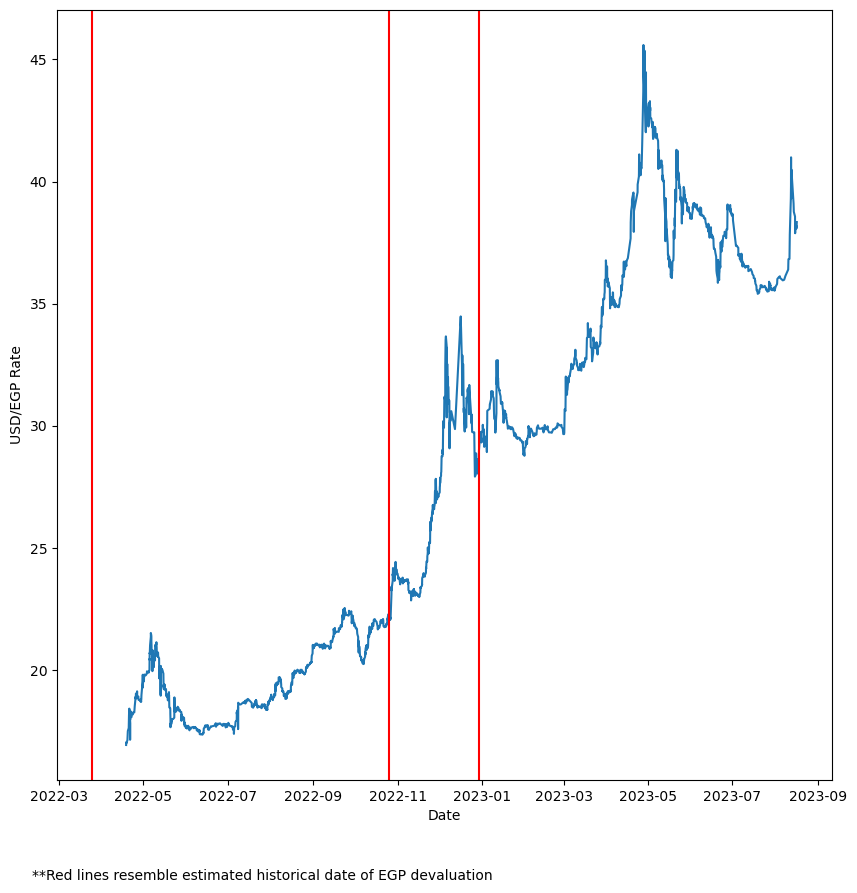

In [64]:
plt.figure(figsize=(10,10))
plt.plot_date(x=ex_rate[['date']],y=ex_rate[['USD/EGP Rate']],fmt='-')
plt.axvline(x=pd.to_datetime('2022-3-25'),color='red')
plt.axvline(x=pd.to_datetime('2022-10-26'),color='red')
plt.axvline(x=pd.to_datetime('2022-12-30'),color='red')
plt.xlabel('Date')
plt.ylabel('USD/EGP Rate')
plt.figtext(0.1,0.01,'**Red lines resemble estimated historical date of EGP devaluation')
plt.show()

## How does Gold's conversion rate differ from the official CBE conversion rate? 


In [65]:
ex_rate.head()

,date,g 18k EGP,g 21k EGP,g 24k EGP,Gold Coin EGP,Oz 24k USD,g 24k USD,USD/EGP Rate
4025,2022-04-18 12:09:46+00:00,894.0,1043.0,1191.0,NaN,1993.0,70.301064,16.941422
4026,2022-04-18 12:29:48+00:00,896.0,1045.0,1194.0,NaN,1995.0,70.371611,16.967069
4027,2022-04-18 12:35:45+00:00,897.0,1047.0,1196.0,NaN,1997.0,70.442159,16.978469
4028,2022-04-18 12:53:08+00:00,896.0,1045.0,1194.0,NaN,1995.0,70.371611,16.967069
4029,2022-04-18 13:44:19+00:00,897.0,1047.0,1196.0,NaN,1993.0,70.301064,17.012545


In [66]:
ex_rate = ex_rate.rename(columns={'date':'datetime'})

In [67]:
ex_rate['date'] = ex_rate['datetime'].apply(lambda x:x.strftime('%Y-%m-%d'))

In [68]:
ex_rate.head()

,datetime,g 18k EGP,g 21k EGP,g 24k EGP,Gold Coin EGP,Oz 24k USD,g 24k USD,USD/EGP Rate,date
4025,2022-04-18 12:09:46+00:00,894.0,1043.0,1191.0,NaN,1993.0,70.301064,16.941422,2022-04-18
4026,2022-04-18 12:29:48+00:00,896.0,1045.0,1194.0,NaN,1995.0,70.371611,16.967069,2022-04-18
4027,2022-04-18 12:35:45+00:00,897.0,1047.0,1196.0,NaN,1997.0,70.442159,16.978469,2022-04-18
4028,2022-04-18 12:53:08+00:00,896.0,1045.0,1194.0,NaN,1995.0,70.371611,16.967069,2022-04-18
4029,2022-04-18 13:44:19+00:00,897.0,1047.0,1196.0,NaN,1993.0,70.301064,17.012545,2022-04-18


In [69]:
starting_time = ex_rate.groupby('date').agg({'datetime':'min'})
starting_time = starting_time.reset_index()

In [70]:
ex_ratev2=starting_time.merge(ex_rate,how='left',left_on='datetime',right_on='datetime')

In [71]:
ex_ratev2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 469 entries, 0 to 468
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   date_x         469 non-null    object             
 1   datetime       469 non-null    datetime64[ns, UTC]
 2   g 18k EGP      469 non-null    float64            
 3   g 21k EGP      469 non-null    float64            
 4   g 24k EGP      469 non-null    float64            
 5   Gold Coin EGP  313 non-null    float64            
 6   Oz 24k USD     469 non-null    float64            
 7   g 24k USD      469 non-null    float64            
 8   USD/EGP Rate   469 non-null    float64            
 9   date_y         469 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(7), object(2)
memory usage: 40.3+ KB


In [72]:
ex_ratev3 = ex_ratev2[['date_x','USD/EGP Rate']]
ex_ratev3 = ex_ratev3.rename(columns={'date_x':'Date','USD/EGP Rate':'Gold Exchange Rate USD/EGP'})
ex_ratev3['Date'] = pd.to_datetime(ex_ratev3['Date'])

In [73]:
ex_ratev2['date_x'] = pd.to_datetime(ex_ratev2['date_x'])

In [74]:
ex_ratev3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 469 entries, 0 to 468
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        469 non-null    datetime64[ns]
 1   Gold Exchange Rate USD/EGP  469 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.0 KB


In [75]:
fx_comp = ex_ratev3.merge(cbe_dfv2,how='left',left_on='Date',right_on='Date')

In [76]:
fx_comp.head()

,Date,Gold Exchange Rate USD/EGP,CBE Exchange Rate USD/EGP
0,2022-04-18,16.941422,18.4681
1,2022-04-19,17.130214,18.4983
2,2022-04-20,17.621874,18.5178
3,2022-04-21,17.825932,18.5983
4,2022-04-22,18.088564,NaN


In [77]:
fx_comp_v2=fx_comp.dropna()
fx_comp_v2['CBE Exchange Rate USD/EGP'] = fx_comp_v2['CBE Exchange Rate USD/EGP'].astype(float)

/tmp/ipykernel_20/1804936907.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fx_comp_v2['CBE Exchange Rate USD/EGP'] = fx_comp_v2['CBE Exchange Rate USD/EGP'].astype(float)


In [78]:
fx_comp_v2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286 entries, 0 to 468
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        286 non-null    datetime64[ns]
 1   Gold Exchange Rate USD/EGP  286 non-null    float64       
 2   CBE Exchange Rate USD/EGP   286 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 8.9 KB


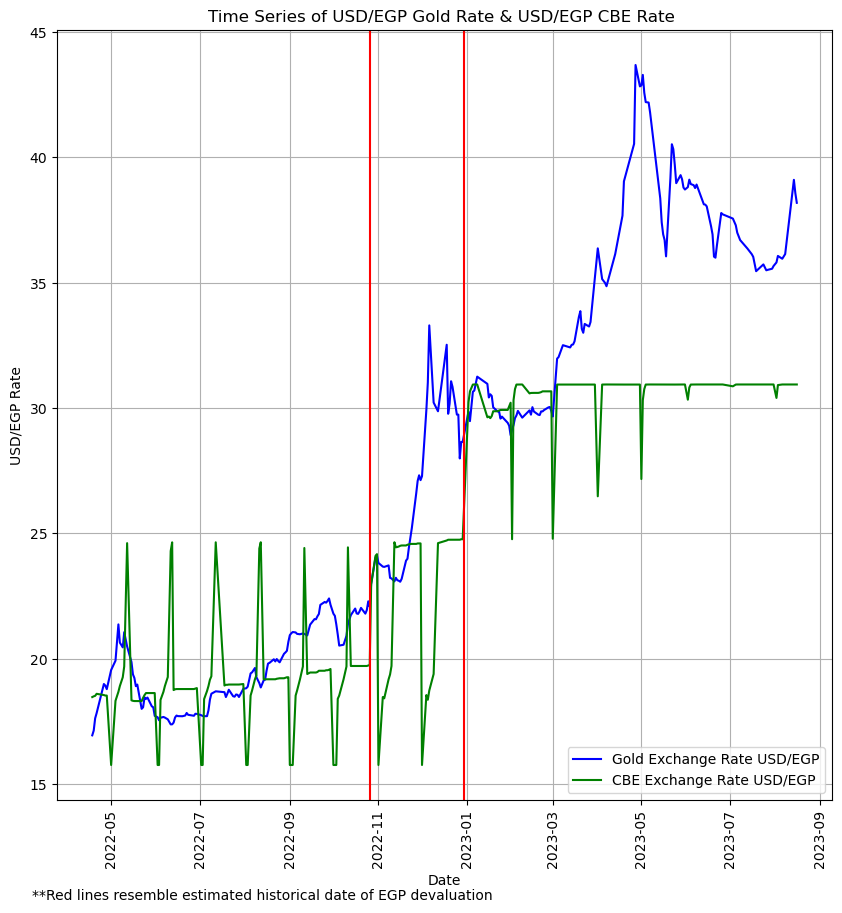

In [79]:
plt.figure(figsize=(10,10))
plt.title('Time Series of USD/EGP Gold Rate & USD/EGP CBE Rate ')
plt.plot_date(x=fx_comp_v2[['Date']],y=fx_comp_v2[['Gold Exchange Rate USD/EGP']],fmt='b-', label='Gold Exchange Rate USD/EGP')
plt.plot_date(x=fx_comp_v2[['Date']],y=fx_comp_v2[['CBE Exchange Rate USD/EGP']],fmt='g-',label='CBE Exchange Rate USD/EGP')
#plt.axvline(x=pd.to_datetime('2022-3-25'),color='red')
plt.axvline(x=pd.to_datetime('2022-10-26'),color='red')
plt.axvline(x=pd.to_datetime('2022-12-30'),color='red')
plt.xlabel('Date')
plt.ylabel('USD/EGP Rate')
plt.legend(loc='lower right')
plt.grid()
plt.xticks(rotation='vertical')
plt.figtext(0.1,0.01,'**Red lines resemble estimated historical date of EGP devaluation')
plt.show()

### Exploring the Gap

In [80]:
fx_comp_v2['Difference'] = fx_comp_v2['Gold Exchange Rate USD/EGP'] - fx_comp_v2['CBE Exchange Rate USD/EGP']

/tmp/ipykernel_20/2841195590.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fx_comp_v2['Difference'] = fx_comp_v2['Gold Exchange Rate USD/EGP'] - fx_comp_v2['CBE Exchange Rate USD/EGP']


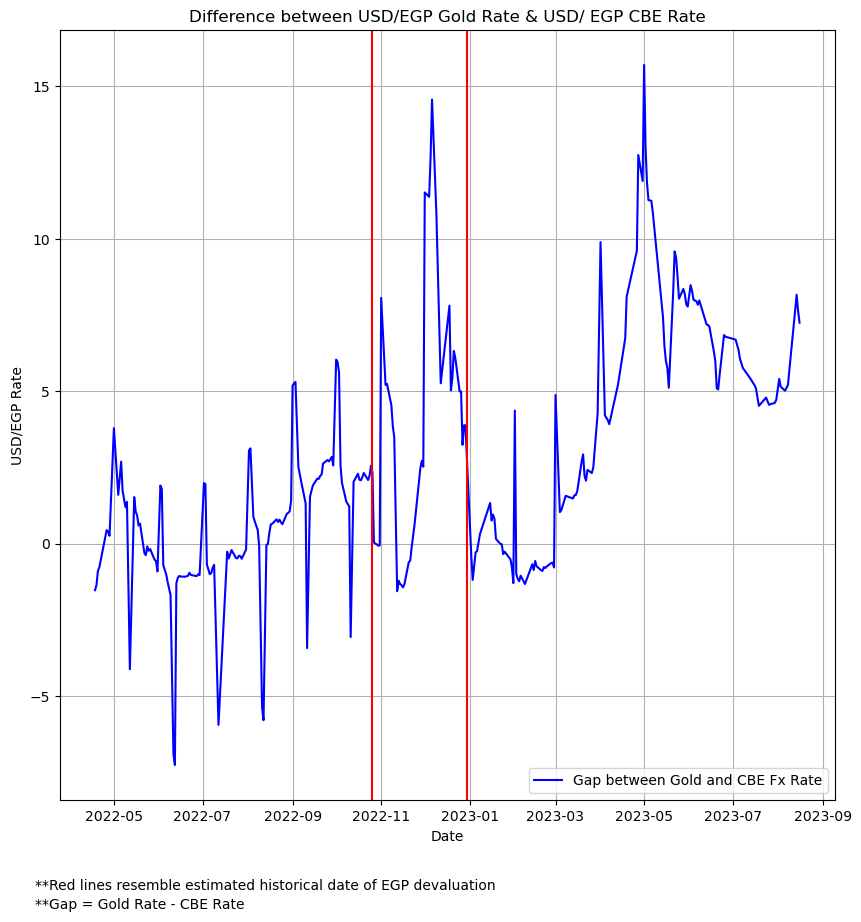

In [81]:
plt.figure(figsize=(10,10))
plt.title('Difference between USD/EGP Gold Rate & USD/ EGP CBE Rate')
plt.plot_date(x=fx_comp_v2[['Date']],y=fx_comp_v2[['Difference']],fmt='b-', label='Gap between Gold and CBE Fx Rate')
plt.axvline(x=pd.to_datetime('2022-10-26'),color='red')
plt.axvline(x=pd.to_datetime('2022-12-30'),color='red')
plt.xlabel('Date')
plt.ylabel('USD/EGP Rate')
plt.legend(loc='lower right')
plt.grid()
#plt.xticks(rotation='vertical')
plt.figtext(0.1,0.02,'**Red lines resemble estimated historical date of EGP devaluation')
plt.figtext(0.1,0.001,'**Gap = Gold Rate - CBE Rate')
plt.show()

**What happened in May that decreased the gap between golds conversion rate and cbe conversion rate?**

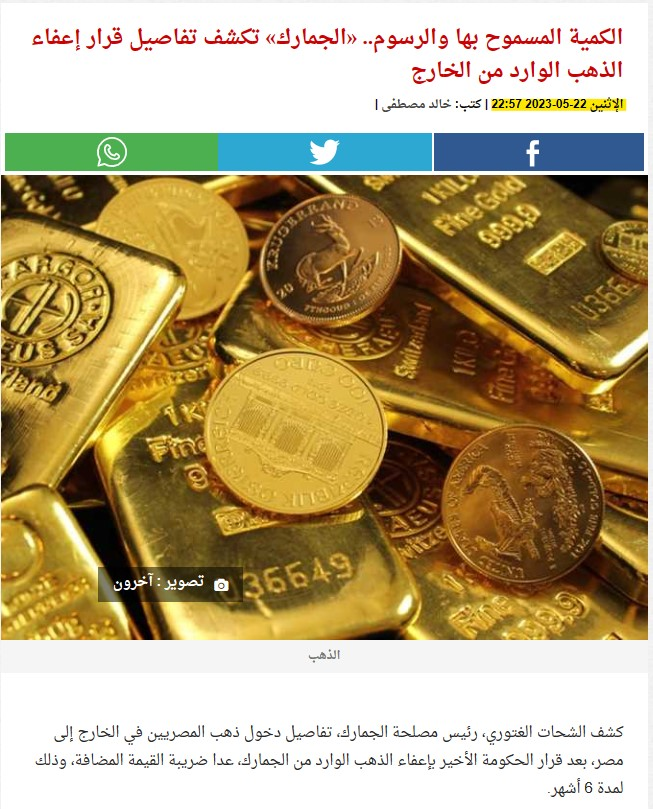

In [82]:
Image('/kaggle/input/goldnews/goldnews.jpg')

The Government Exempted Tarrifs on Gold for six Months

https://www.almasryalyoum.com/news/details/2893115

In [83]:
fx_comp_v2

,Date,Gold Exchange Rate USD/EGP,CBE Exchange Rate USD/EGP,Difference
0,2022-04-18,16.941422,18.4681,-1.526678
1,2022-04-19,17.130214,18.4983,-1.368086
2,2022-04-20,17.621874,18.5178,-0.895926
3,2022-04-21,17.825932,18.5983,-0.772368
8,2022-04-26,18.989097,18.5489,0.440197
...,...,...,...,...
459,2023-08-06,35.955107,30.9386,5.016507
461,2023-08-08,36.141210,30.9386,5.202610
466,2023-08-14,39.102759,30.9386,8.164159
467,2023-08-15,38.569025,30.9386,7.630425


In [84]:
gold_df_v2['g Gold USD'] = gold_df_v2['Oz Gold USD']/28.3495

In [85]:
gold_df_v2 = gold_df_v2.rename({'g Gold USD':'Intl. g Gold USD'},axis=1)

In [86]:
gold_df_v3 = ex_ratev2.merge(gold_df_v2,how='left',left_on='date_x',right_on='Date')

In [87]:
gold_df_v3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 469 entries, 0 to 468
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   date_x            469 non-null    datetime64[ns]     
 1   datetime          469 non-null    datetime64[ns, UTC]
 2   g 18k EGP         469 non-null    float64            
 3   g 21k EGP         469 non-null    float64            
 4   g 24k EGP         469 non-null    float64            
 5   Gold Coin EGP     313 non-null    float64            
 6   Oz 24k USD        469 non-null    float64            
 7   g 24k USD         469 non-null    float64            
 8   USD/EGP Rate      469 non-null    float64            
 9   date_y            469 non-null    object             
 10  Date              327 non-null    datetime64[ns]     
 11  Oz Gold USD       327 non-null    float64            
 12  Intl. g Gold USD  327 non-null    float64            
dtypes: da

In [88]:
gold_df_v3.head()

,date_x,datetime,g 18k EGP,g 21k EGP,g 24k EGP,Gold Coin EGP,Oz 24k USD,g 24k USD,USD/EGP Rate,date_y,Date,Oz Gold USD,Intl. g Gold USD
0,2022-04-18,2022-04-18 12:09:46+00:00,894.0,1043.0,1191.0,NaN,1993.0,70.301064,16.941422,2022-04-18,2022-04-18,1978.5,69.789591
1,2022-04-19,2022-04-19 10:20:18+00:00,896.0,1045.0,1194.0,NaN,1976.0,69.701406,17.130214,2022-04-19,2022-04-19,1981.2,69.884830
2,2022-04-20,2022-04-20 08:58:36+00:00,906.0,1058.0,1209.0,NaN,1945.0,68.607912,17.621874,2022-04-20,2022-04-20,1952.7,68.879522
3,2022-04-21,2022-04-21 08:58:20+00:00,917.0,1070.0,1223.0,NaN,1945.0,68.607912,17.825932,2022-04-21,2022-04-21,1960.0,69.137022
4,2022-04-22,2022-04-22 10:59:43+00:00,926.0,1080.0,1234.0,NaN,1934.0,68.219898,18.088564,2022-04-22,2022-04-22,1953.1,68.893631


In [89]:
gold_df_v4 = gold_df_v3[['Date','g 24k USD','Intl. g Gold USD','g 24k EGP']]

In [90]:
gold_df_v4.head()

,Date,g 24k USD,Intl. g Gold USD,g 24k EGP
0,2022-04-18,70.301064,69.789591,1191.0
1,2022-04-19,69.701406,69.884830,1194.0
2,2022-04-20,68.607912,68.879522,1209.0
3,2022-04-21,68.607912,69.137022,1223.0
4,2022-04-22,68.219898,68.893631,1234.0


In [91]:
gold_df_v5 = gold_df_v4[gold_df_v4['Date'].notnull()]

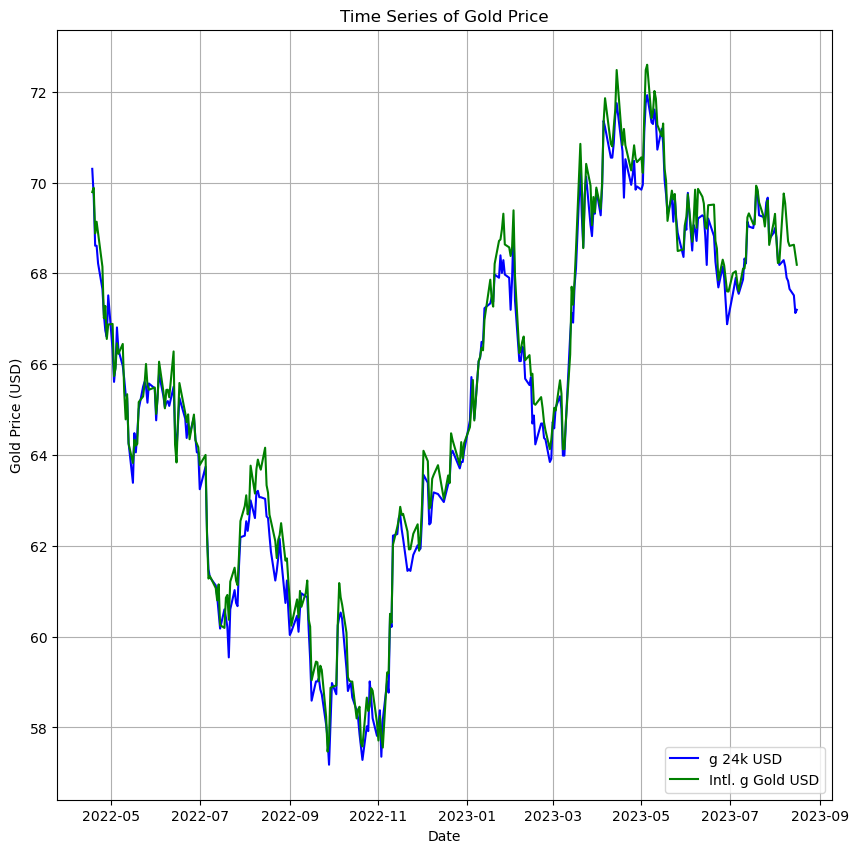

In [92]:
plt.figure(figsize=(10,10))
plt.title('Time Series of Gold Price')
plt.plot_date(x=gold_df_v5[['Date']],y=gold_df_v5[['g 24k USD']],fmt='b-', label='g 24k USD')
plt.plot_date(x=gold_df_v5[['Date']],y=gold_df_v5[['Intl. g Gold USD']],fmt='g-',label='Intl. g Gold USD')
plt.xlabel('Date')
plt.ylabel('Gold Price (USD)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [93]:
gold_df_v5['Difference'] = gold_df_v5['g 24k USD'] - gold_df_v5['Intl. g Gold USD']

/tmp/ipykernel_20/1581440139.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gold_df_v5['Difference'] = gold_df_v5['g 24k USD'] - gold_df_v5['Intl. g Gold USD']


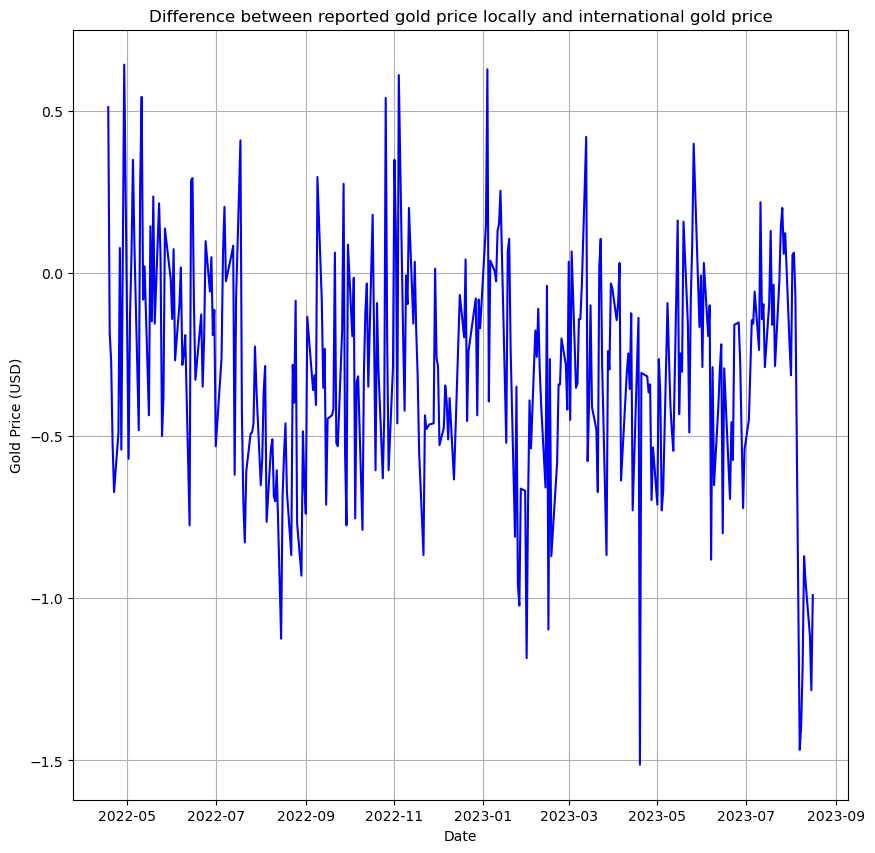

In [94]:
plt.figure(figsize=(10,10))
plt.title('Difference between reported gold price locally and international gold price')
plt.plot_date(x=gold_df_v5[['Date']],y=gold_df_v5[['Difference']],fmt='b-', label='Difference')
plt.xlabel('Date')
plt.ylabel('Gold Price (USD)')
#plt.legend(loc='lower right')
plt.grid()
plt.show()

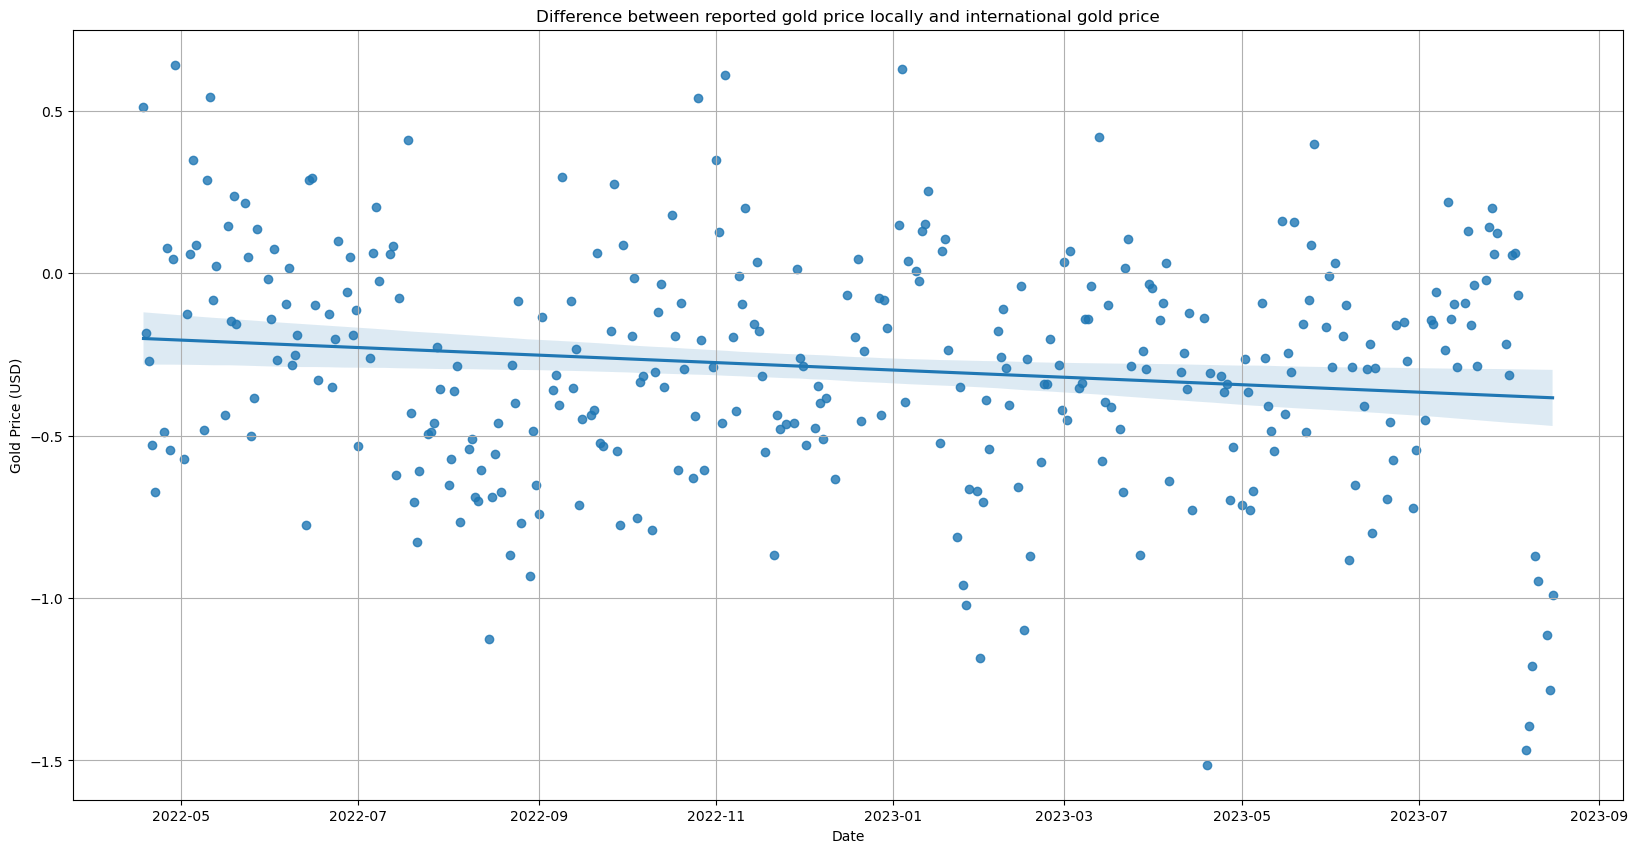

In [95]:
f, ax = plt.subplots(figsize=(20,10))
ax.xaxis.update_units(gold_df_v5[['Date']])
plt.title('Difference between reported gold price locally and international gold price')
sns.regplot(x=ax.xaxis.convert_units(gold_df_v5[['Date']]),y=gold_df_v5[['Difference']])
plt.xlabel('Date')
plt.ylabel('Gold Price (USD)')
plt.grid()
plt.show()

# Conclusion
- There is a constant gap between the official USD/EGP price and the USD/EGP price used to price Gold.
- The Gap was at its highest in May 2023 and was brought down by the governments initiative to exempt tarrifs on Gold Imports.